In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image

In [3]:
# Data Type Issue:

# OpenCV images are typically loaded as uint8 (values in the range [0, 255]), and Gaussian noise is also cast to uint8. Adding two uint8 arrays could lead to overflow (values wrapping around, e.g., 250 + 20 → 14).
# Solution: Perform the addition in a higher precision format, such as float32, and clip the resulting values to ensure they remain within the valid range [0, 255].

class CustomImageDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        """
        Args:
            img_folder (str): Path to the folder containing images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_folder = img_folder
        self.transform = transform
        self.img_paths = [os.path.join(img_folder, fname) for fname in os.listdir(img_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)  # Read image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Convert image to float32 for safe addition
        img = img.astype(np.float32)

        # Add Gaussian noise
        noise = np.random.normal(0, 100, img.shape).astype(np.float32)  # Mean 0, Std 20
        noisy_img = img + noise

        # Clip values to [0, 255] and convert back to uint8
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

        if self.transform:
            img = self.transform(img.astype(np.uint8))  # Apply transform to original image
            noisy_img = self.transform(noisy_img)       # Apply transform to noisy image

        return img, noisy_img

In [4]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),   # Convert numpy array to PIL image
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor(),  # Convert image to Tensor
])

In [5]:
# Load datasets
train_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_preprocess/train", transform=transform)
val_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_preprocess/val", transform=transform)
test_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_preprocess/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset size
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 15000
Validation samples: 10000
Test samples: 5000


In [6]:
# Get the first batch
data_batch = next(iter(train_loader))

# Unpack the batch Original and Noisy Image
img, noisy_img = data_batch

# Print the shapes
print(f"Original Images Shape: {img.shape}")
print(f"Noisy Images Shape: {noisy_img.shape}")

Original Images Shape: torch.Size([64, 3, 256, 256])
Noisy Images Shape: torch.Size([64, 3, 256, 256])


In [5]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x64

        # input: 128x128x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x128

        #input: 64x64x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #output: 32x32x256

        #input: 32x32x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x512

        #input: 16x16x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 16x16x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 16x16x1024

        # Decoder
        # input: 16x16x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # ouput: 32x32x512
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 32x32x512

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 64x64x256
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x256

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 128x128x128
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x128x128

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 256x256x64
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 256x256x64

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 256x256x3

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 =relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1) # The dim=1 indicates concatenation along the channel dimension (feature maps). For example:If the encoder produces a feature map with shape (batch_size, 64, H, W) and the upsampled decoder map is (batch_size, 64, H, W), after concatenation, the result is (batch_size, 128, H, W).
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=3)
model = model.to(device)
from torchsummary import summary
summary(model, input_size=(3, 256, 256), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 256, 256]           1,792
            Conv2d-2         [64, 64, 256, 256]          36,928
         MaxPool2d-3         [64, 64, 128, 128]               0
            Conv2d-4        [64, 128, 128, 128]          73,856
            Conv2d-5        [64, 128, 128, 128]         147,584
         MaxPool2d-6          [64, 128, 64, 64]               0
            Conv2d-7          [64, 256, 64, 64]         295,168
            Conv2d-8          [64, 256, 64, 64]         590,080
         MaxPool2d-9          [64, 256, 32, 32]               0
           Conv2d-10          [64, 512, 32, 32]       1,180,160
           Conv2d-11          [64, 512, 32, 32]       2,359,808
        MaxPool2d-12          [64, 512, 16, 16]               0
           Conv2d-13         [64, 1024, 16, 16]       4,719,616
           Conv2d-14         [64, 1024,

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
epochs = 50

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

# Set up early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
best_loss = float('inf') #set to positive infinity to ensure that the first validation loss encountered will always be considered an improvement
counter = 0  # Counter to keep track of consecutive epochs with no improvement

#Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for train_clean_images, train_noisy_images in train_loader:
        train_clean_images, train_noisy_images = train_clean_images.to(device), train_noisy_images.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_noisy_images)
        # Find the Loss
        train_loss = criterion(train_outputs, train_clean_images)
        # Calculate gradients
        train_loss.backward()
        # Update Weights
        optimizer.step()

        # accumulate the training loss
        running_loss += train_loss.item()
            
    train_total_loss = running_loss / len(train_loader)
    train_losses.append(train_total_loss)

    #Validation
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for val_clean_images, val_noisy_images in val_loader:
            val_clean_images, val_noisy_images = val_clean_images.to(device), val_noisy_images.to(device)
            val_op = model(val_noisy_images)
            val_loss = criterion(val_op, val_clean_images)
            val_running_loss += val_loss.item()
        
        val_total_loss = val_running_loss / len(val_loader)
        val_losses.append(val_total_loss)

    # Check if validation loss has improved
    if val_total_loss < best_loss:
        best_loss = val_total_loss
        counter = 0
        # Save the model if needed
        torch.save(model.state_dict(), 'best_model.pth')

    else:
        counter += 1

        # Check if training should be stopped
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss:.4f},  Validation Loss: {val_total_loss: .4f}, Best Loss: {best_loss: .4f}')

    sampled_noisy_image = train_noisy_images[0:1:,:,:,:]
    sampled_clean_image = train_clean_images[0:1:,:,:,]
    sampled_train_output = train_outputs[0:1:,:,:,:]
    save_image(sampled_noisy_image, 'trainnoisyimagebeforeunet.png')
    save_image(sampled_clean_image, 'traintargetcleanimage.png')
    save_image(sampled_train_output, 'traincleanimageafterunet.png')

Epoch 1/50, Training Loss: 0.0358,  Validation Loss:  0.0041, Best Loss:  0.0041
Epoch 2/50, Training Loss: 0.0034,  Validation Loss:  0.0030, Best Loss:  0.0030
Epoch 3/50, Training Loss: 0.0028,  Validation Loss:  0.0030, Best Loss:  0.0030
Epoch 4/50, Training Loss: 0.0026,  Validation Loss:  0.0026, Best Loss:  0.0026
Epoch 5/50, Training Loss: 0.0024,  Validation Loss:  0.0023, Best Loss:  0.0023
Epoch 6/50, Training Loss: 0.0022,  Validation Loss:  0.0021, Best Loss:  0.0021
Epoch 7/50, Training Loss: 0.0021,  Validation Loss:  0.0020, Best Loss:  0.0020
Epoch 8/50, Training Loss: 0.0020,  Validation Loss:  0.0020, Best Loss:  0.0020
Epoch 9/50, Training Loss: 0.0019,  Validation Loss:  0.0019, Best Loss:  0.0019
Epoch 10/50, Training Loss: 0.0019,  Validation Loss:  0.0019, Best Loss:  0.0019
Epoch 11/50, Training Loss: 0.0018,  Validation Loss:  0.0019, Best Loss:  0.0019
Epoch 12/50, Training Loss: 0.0018,  Validation Loss:  0.0018, Best Loss:  0.0018
Epoch 13/50, Training Los

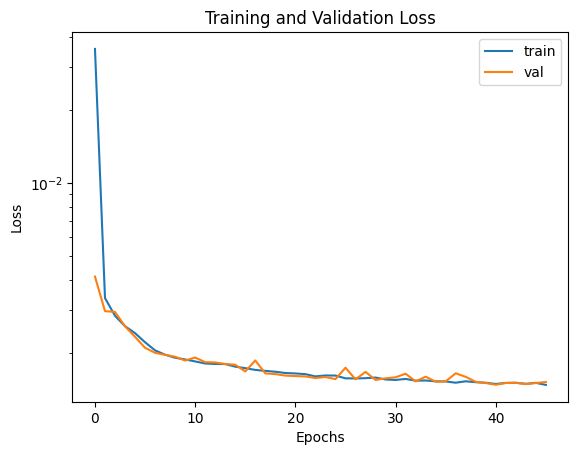

In [9]:
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.show()

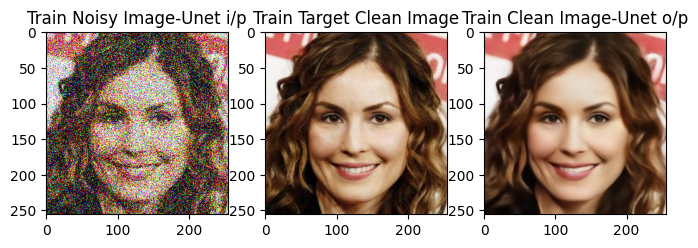

In [13]:
plt.figure(figsize=(8,8))
img1 = mpimg.imread("/home/data/taha/UNET-denoising/full_task/trainnoisyimagebeforeunet.png")
img2 = mpimg.imread("/home/data/taha/UNET-denoising/full_task/traintargetcleanimage.png")
img3 = mpimg.imread("/home/data/taha/UNET-denoising/full_task/traincleanimageafterunet.png")
plt.subplot(1,3,1).set_title("Train Noisy Image-Unet i/p")
plt.imshow(img1)
plt.subplot(1,3,2).set_title("Train Target Clean Image")
plt.imshow(img2)
plt.subplot(1,3,3).set_title("Train Clean Image-Unet o/p")
plt.imshow(img3)
plt.show()

In [14]:
#Validation
model.eval()

with torch.no_grad():
    for test_clean_images, test_noisy_images in test_loader:
        test_clean_images, test_noisy_images = test_clean_images.to(device), test_noisy_images.to(device)
        test_outputs = model(test_noisy_images)

sampled_test_noisy_image = test_noisy_images[0:1,:,:,:]
sampled_test_clean = test_clean_images[0:1,:,:,:]
sampled_test_output = test_outputs[0:1:,:,:,:]   

save_image(sampled_test_noisy_image, 'testnoisyimagebeforeunet.png')
save_image(sampled_test_clean, 'testtargetcleanimage.png')
save_image(sampled_test_output, 'testcleanimageafterunet.png')

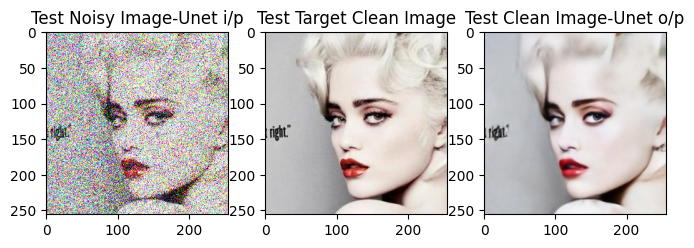

In [15]:
plt.figure(figsize=(8,8))
img4 = mpimg.imread("/home/data/taha/UNET-denoising/full_task/testnoisyimagebeforeunet.png")
img5 = mpimg.imread("/home/data/taha/UNET-denoising/full_task/testtargetcleanimage.png")
img6 = mpimg.imread("/home/data/taha/UNET-denoising/full_task/testcleanimageafterunet.png")
plt.subplot(1,3,1).set_title("Test Noisy Image-Unet i/p")
plt.imshow(img4)
plt.subplot(1,3,2).set_title("Test Target Clean Image")
plt.imshow(img5)
plt.subplot(1,3,3).set_title("Test Clean Image-Unet o/p")
plt.imshow(img6)
plt.show()